# Modelling Non-equilibrium, Brownian Particles Using Python


In [16]:
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import ipywidgets as widgets
plt.style.use('seaborn-notebook')
# Larger plots for high dpi images
%config InlineBackend.figure_format = 'retina'

## Task 3 Probability Flux in State Space of Coupled Brownian Harmonic Oscillators

Subtask 1: Implement the Brownian dynamics simulation of two harmonic oscillators which are connect by a spring:
$$
\frac{dx_1}{dt} = \frac{1}{\zeta}\ k~(x_2-2x_1) + \Gamma_1 \\
\frac{dx_2}{dt} = \frac{1}{\zeta}\ k~(x_1-2x_2) + \Gamma_2
$$
Use the following parameters for the simulation:
- springconstant $k=1$
- friction coefficent $\zeta=18.849$
- timestep $dt=0.1$

The beats should be couppled to heat bathes with two different tempratures T1 and T2. The noises $\Gamma_1$ and $\Gamma_2$ follow a normal distribution with zero mean and variance $\sigma = 2k_B T_1 \tau/\zeta$.

Hint: Calculate first the noise array. Then use a for loop to integrate the dynamamics of the beats. Save the position of each bead as a position touple in a list, e.g. data = [($x_1^0$, $x_2^0$), ($x_1^1$, $x_2^1$), ($x_1^t$, $x_2^t$ )]

In [3]:
def langevin_simulation(steps, T1, T2):
    # fixed parameters
    dt = 0.1
    xi = 18.849
    springk = 1.0
    nstd1 = np.sqrt(2.*T1*dt/xi)
    nstd2 = np.sqrt(2.*T2*dt/xi)
    
    # initialise positions of beads
    x1, x2 = 0., 0.
    
    data = []
    
    # Get random number between 0 and 1
    noise_T1 = np.random.normal(loc=0., scale=nstd1, size=steps)
    noise_T2 = np.random.normal(loc=0., scale=nstd2, size=steps)

    # Time loop
    for ti in range(steps):
        x1 += springk*(x2-2*x1)*dt/xi + noise_T1[ti]
        x2 += springk*(x1-2*x2)*dt/xi + noise_T2[ti]
        
        data.append((x1, x2))
        
    return np.array(data)


## Task 3a Analyze Results
Task: Run the simulation for `N=10000` timesteps with different temperatures `T1` and `T2`. Look at the changes of the trajectories $x_1(t)$, $x_2(t)$ and the center of mass. How would you interpret the results?

In [30]:
N = 10000
data = langevin_simulation(N, T1=1, T2=1.0)

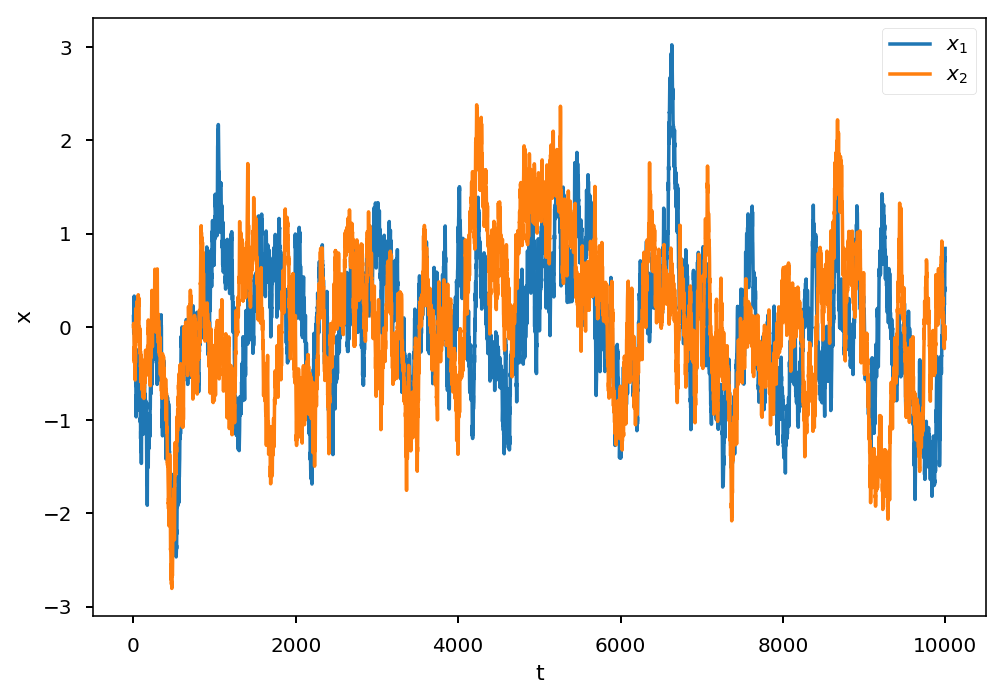

In [31]:
plt.plot(data.T[0], label=r"$x_1$")
plt.plot(data.T[1], label=r"$x_2$")

plt.xlabel("t")
plt.ylabel("x")
plt.legend()

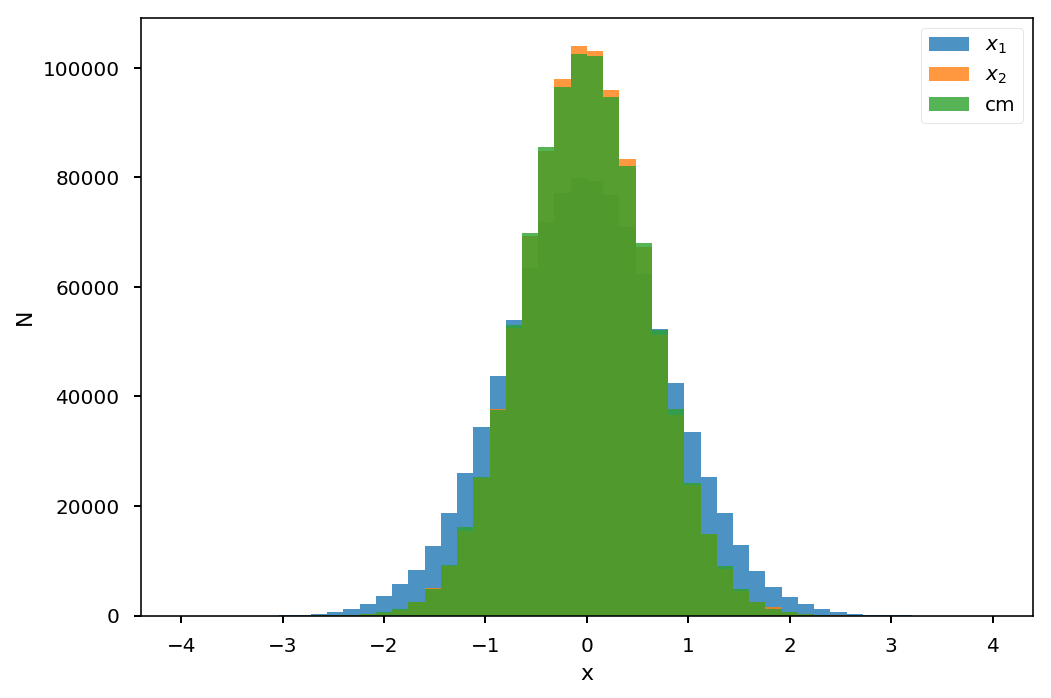

In [21]:
binnum = 50
bins = np.linspace(-4, 4, binnum + 1)

hist = plt.hist(data.T[0], label=r"$x_1$", bins=bins, alpha=0.8)
plt.hist(data.T[1], label=r"$x_2$", bins=bins, alpha=0.8)
plt.hist((data.T[0] + data.T[1])/2.0, label=r"cm", bins=bins, alpha=0.8)
plt.xlabel("x")
plt.ylabel("N")
plt.legend()

## Bonus - Interactive Animation of the Oscialltors
A short visualisation of the fluctuating oscillators. Play around with it to get an idea how the simulation results look like

In [36]:
%matplotlib agg
import matplotlib.animation

def animate(t=0):
    fr = data[t]
    l1.set_offsets([fr[0], 0])
    l2.set_offsets([fr[1], 0])
    t1.set_text("t={}".format(t))


fig, ax = plt.subplots()
l1 = ax.scatter([],[], s=50)
l2 = ax.scatter([],[], s=150)
t1 = ax.text(0.04,0.02, "t=0")
ax.set_xlim(-4,4)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_jshtml())

%matplotlib inline

## Task 3b Probability flux analysis

Task: Analyze the probability flux for different temperatures. Change the number of bins, number of simulations and the length of the simulation.  Interpret the results.

In [37]:
# Generate Statistics
binnum = 10
bins = np.linspace(-4, 4, binnum + 1)

M = 5 # number of simulations
N = int(1e6) # timestemps down

T1 = 1.0 
T2 = 0.5

ensemble = []
for k in range(M):
    ensemble.append(langevin_simulation(N, T1, T2))
ensemble_flatten = np.array(ensemble).reshape(-1,2)

In [38]:
def get_flux(data, xbins, ybins):
    # initialize fluxes
    flux = np.zeros((len(xbins)-1, len(ybins)-1, 2))
    fluxt = np.zeros((len(xbins)-1, len(ybins)-1,2))

    # digitize positions in phase space (0=<digg<15)
    # -1 to convert to array indices as per counts
    x1dig = np.digitize(data.T[0], xbins[:-1])-1
    x2dig = np.digitize(data.T[1], ybins[:-1])-1
    digg = np.vstack((x1dig,x2dig)).T
    digg_diff = np.diff(digg,axis=0)

    # This is just a fancy loop over all the time steps
    for (i,j),(d1,d2) in zip(digg[:-1], digg_diff):

        # up
        if d1==1 and d2==0:
            flux[ i  , j, 0]+=1;
            flux[ i+1, j, 0]+=1;

        # down
        elif d1==-1 and d2==0:
            flux[ i  , j, 0]-=1;
            flux[ i-1, j, 0]-=1;

        # right
        elif d1==0 and d2==1:
            flux[ i, j, 1]  +=1;
            flux[ i, j+1, 1]+=1;

        # left
        elif d1==0 and d2==-1:
            flux[ i, j, 1]  -=1;
            flux[ i, j-1, 1]-=1;
    return flux

In [39]:

hist, binsx, binsy = np.histogram2d(ensemble_flatten.T[0], ensemble_flatten.T[1], bins=bins)

fluxes = []
for data in ensemble:
    fluxes.append(get_flux(data, binsx, binsy))
fluxes = np.array(fluxes)
flux = fluxes.mean(axis=0)

In [40]:

xc = (binsx[1:]+binsx[:-1])/2.0
X,Y = np.meshgrid(xc,xc)
flux_norm = flux /2./N

(-2, 2)

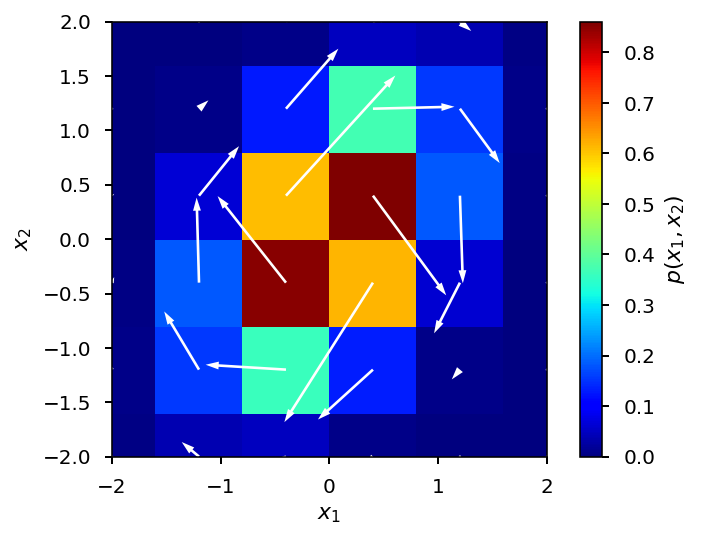

In [41]:
ax = plt.subplot(111)

ax.quiver( X, Y, 
          flux_norm[:,:,1], flux_norm[:,:,0], 
          scale=1./10000., scale_units="xy", 
          headaxislength=5, color="white")


im = ax.imshow(hist/N, extent=(binsx[0], binsx[-1],binsy[0],binsy[-1]),
                cmap=mpl.cm.jet, 
                origin='lower')
plt.colorbar(im, label="$p(x_1,x_2)$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)